In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

In [7]:
def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.
    
    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """
    
    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")
    
    # Reproject to Web Mercator to align with basemap 
    gdf = gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]
    
    # Plot noise points 
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')
    
    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)
    
    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)
    
    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [12]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")
df.head()

Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766

In [19]:
df['ODCAF_Facility_Type'].value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [26]:
df= df[df['ODCAF_Facility_Type']=="museum"]
X= df[['Latitude', 'Longitude']]

In [29]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [41]:
X = X[X != '..']
X = X.astype("float64")

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   1607 non-null   float64
 1   Longitude  1607 non-null   float64
dtypes: float64(2)
memory usage: 45.4 KB


In [62]:
X.isnull().sum()

Latitude     331
Longitude    331
dtype: int64

In [66]:
X = X.dropna()

In [68]:
# latitude (-90, +90), longitude (-180, +180)
coords_scaled = X.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

min_samples=3 
eps=1.0
metric='euclidean'
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

In [96]:
X['Cluster'] = dbscan.fit_predict(coords_scaled)
dbscan_labels = dbscan.labels_
X['Cluster'].value_counts()

Cluster
 4     701
 2     192
 1     181
 7     134
 3      94
-1      79
 6      30
 10     27
 8      21
 11     15
 15     13
 20     11
 16     10
 19      9
 27      8
 12      7
 24      6
 18      6
 28      6
 26      6
 14      6
 5       6
 22      4
 9       4
 13      4
 30      3
 31      3
 29      3
 0       3
 25      3
 23      3
 21      3
 17      3
 32      3
Name: count, dtype: int64

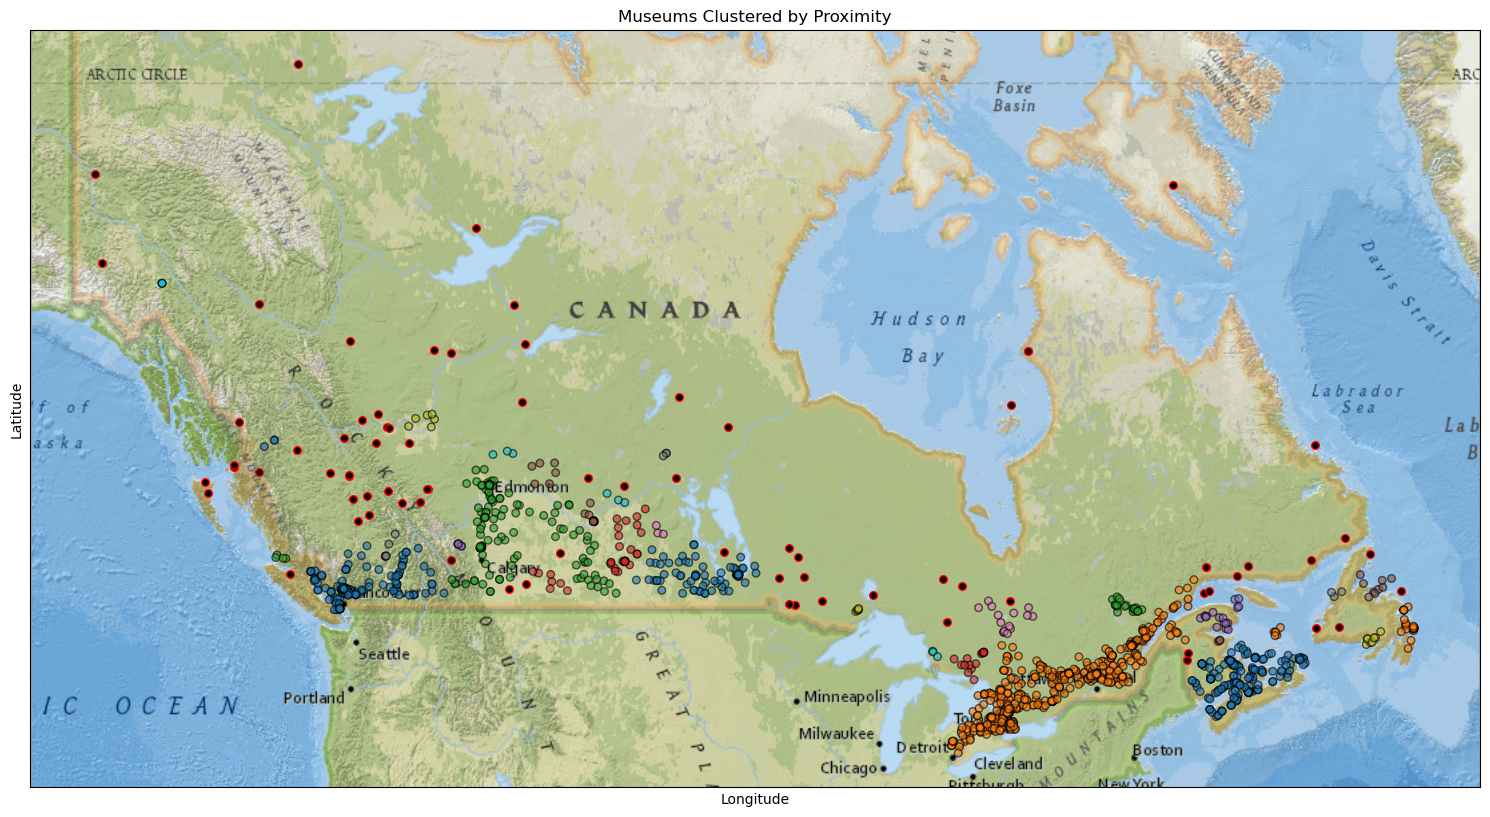

In [78]:
plot_clustered_locations(X, title='Museums Clustered by Proximity')

In [81]:
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')

In [94]:
X['Cluster'] = hdb.fit_predict(coords_scaled)
hdbscan_labels = hdb.labels_
X['Cluster'].value_counts()

Cluster
-1      462
 139     45
 94      39
 59      34
 84      28
       ... 
 0        3
 135      3
 103      3
 111      3
 44       3
Name: count, Length: 143, dtype: int64

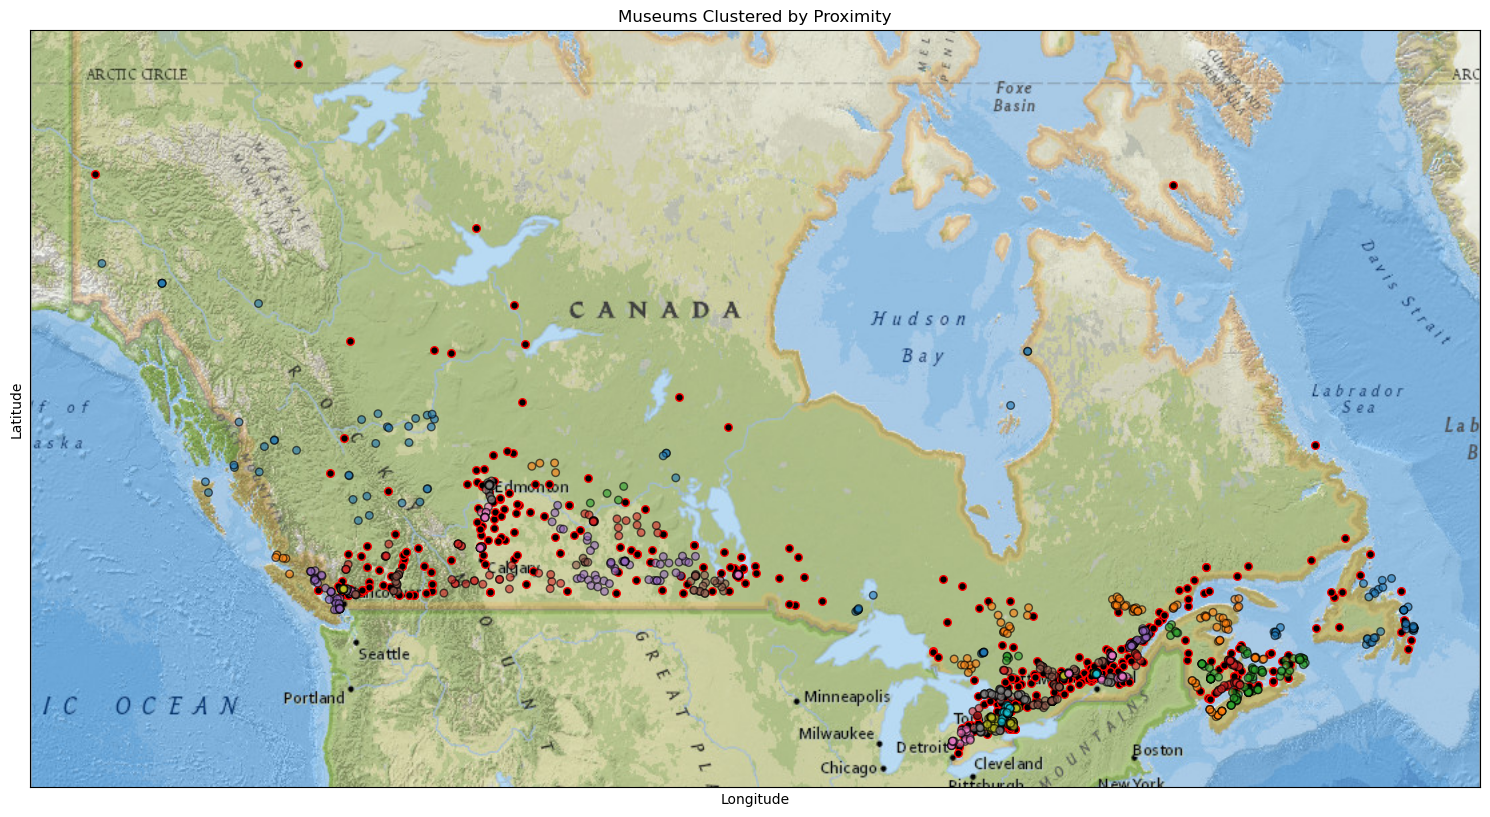

In [87]:
plot_clustered_locations(X, title='Museums Clustered by Proximity')

In [98]:
dbscan_noise = np.sum(dbscan_labels == -1)
hdbscan_noise = np.sum(hdbscan_labels == -1)

print(f"DBSCAN Noise Points: {dbscan_noise}")
print(f"HDBSCAN Noise Points: {hdbscan_noise}")

DBSCAN Noise Points: 79
HDBSCAN Noise Points: 462
